## Portfolio Exercise: Starbucks
### Table of Contents:

- [Background Information](#Back)
- [Part I](#Part1)
    - [Part I Conclusion](#Part1Conc)
- [Part II](#Part2)
    - [Part II Conclusion](#Part2Conc)
- [Part III](#Part3)
    - [Part III Conclusion](#Part3Conc)
- [Model Creation/Testing](#Part4)
    - [Model Conclusion](#Part4Conc)



<a id="Back"></a>
### Background Information

This dataset was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Our task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

We will complete the `promotion_strategy` function to pass to the `test_results` function. This will test our optimization strategy.   
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

We will start by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  

**Let's Go!**

In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [45]:
train_data.shape

(84534, 10)

<a id="Part1"></a>
### Part I. 
My first step will be to analyze our invariant metric of number of participants in our control and experiment (i.e those who recieved a promotional offer vs those who did not).

Hypothesis:
$$H_{0}: Exp_{particiapants} - Control_{participants} = 0$$
$$H_{a}: Exp_{participants} - Control_{participants} > 0$$
$$\alpha = 0.05$$


In [44]:
# Checking the number of individuals in each group
print("The number who received the promotion: {} and the number who did not: {}.".format((train_data.Promotion == "Yes").sum(),(train_data.Promotion == "No").sum()))

The number who received the promotion: 42364 and the number who did not: 42170.


In [19]:
# Calculating a measurable statistic in the difference of our group sizes
Promotion_avg = ((train_data.Promotion == "Yes").sum())/train_data.shape[0]
Non_Promotion_avg = (train_data.Promotion == "No").sum()/train_data.shape[0]
sample_difference = Promotion_avg - Non_Promotion_avg

In [12]:
# Bootstraping our differences to get a model of the distribution for our null
differences = []
for _ in range(10000):
    bootsamp = train_data.sample(30000, replace=True)
    Promotion_avg = ((bootsamp.Promotion == "Yes").sum())/bootsamp.shape[0]
    Non_Promotion_avg = (bootsamp.Promotion == "No").sum()/bootsamp.shape[0]
    differences.append(Promotion_avg - Non_Promotion_avg)


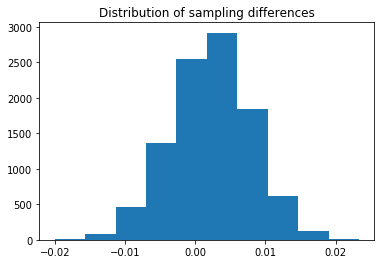

In [30]:
# Visualistion of our distribution 
plt.hist(differences)
plt.title('Normal Distribution of sampling differences');

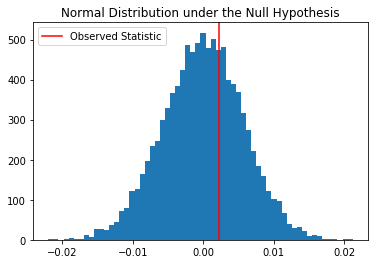

In [41]:
# distribution of our null hypothesis
null_vals = np.random.normal(0, np.std(differences), 10000)
plt.hist(null_vals, bins=60)
plt.axvline(sample_difference, color='r', label ="Observed Statistic")
plt.legend(loc='upper left')
plt.title("Normal Distribution under the Null Hypothesis");

In [166]:
sample_difference

0.00229493458253488

In [112]:
# Determining the signifigance of our result 
p_val = (sample_difference>null_vals).mean()
p_val

0.6525

<a id="Part1Conc"></a>
#### Part I. Conclusion 
Our P value is well within our confidence interval and therefore we **fail to reject the null hypothesis**. This implies that there is no statistical signifigance in the difference of our sampling populations. Awesome! Now, lets move forward with the analysis :) 

<a id="Part2"></a>
### Part II. Analyzing NIR Effect
Below we shall determine if the experiment had a positive effect on the NIR metric. 
Hypothesis:
$$H_{0}:Net Incremental Revenue = 0$$
$$H_{a}:Net Incremental Revenue > 0$$
$$\alpha = 0.05$$
Our *Alpha value* with the Bonferroni Correction:
$$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$

Where: 

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [95]:
# Finding our observed statistic 
purchase_treatment = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
customer_treatment = train_data[train_data['Promotion'] == "Yes"].shape[0]
purchase_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
NIR = (10*purchase_treatment - 0.15*customer_treatment)-10*purchase_control
NIR


-2334.5999999999995

In [102]:
# Bootstraping our differences to get a model of the distribution for our null
NIRs = []
for _ in range(10000):
    bootsample = train_data.sample(30000, replace=True)
    purchase_treatment = bootsample[bootsample['Promotion'] == "Yes"].purchase.sum()
    customer_treatment = bootsample[bootsample['Promotion'] == "Yes"].shape[0]
    purchase_control = bootsample[bootsample['Promotion'] == "No"].purchase.sum()
    NIRs.append((10*purchase_treatment - 0.15*customer_treatment)-10*purchase_control)

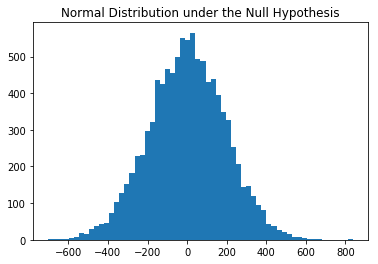

In [120]:
# distribution of our null hypothesis
null_NIRs = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis");

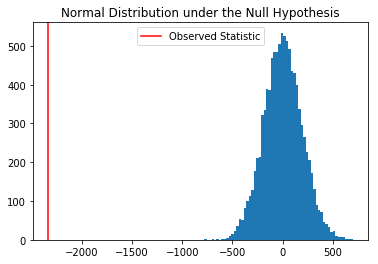

In [119]:
# Plotting under the null 
plt.axvline(NIR, color='r', label ="Observed Statistic")
null_NIRs = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis")
plt.legend();

In [111]:
# Checking the signifigane is 0
pval = (NIR>null_NIRs).mean()
pval

0.0

In [113]:
# Curious check to ensure all the data under the null lies above our observed statistic
pval2 = (NIR<null_NIRs).mean()
pval2

1.0

<a id="Part2Conc"></a>
#### Part II. Conclusion 
Our P value is well below our confidence interval and therefore we **fail to reject our null hypothesis**. This implies that there is no statistical signifigant increase in NIR (what we want to optimise). However, our data indicates we signifigantly REDUCED the NIR with this campaign. Not what we want...
<a id="Part3"></a>
### Part III. Analyzing IIR Effect
Below we shall determine if the experiment had a positive effect on the IIR metric. 
Hypothesis:
$$H_{0}:Incremental Response Rate = 0$$
$$H_{a}:Incremental Response Rate > 0$$
$$\alpha = 0.025$$

Where:
$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [115]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [116]:
# Finding our observed statistic 
purchase_treatment = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
customer_treatment = train_data[train_data['Promotion'] == "Yes"].shape[0]
purchase_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
customer_control = train_data[train_data['Promotion'] == "No"].shape[0]
IRR = purchase_treatment/customer_treatment - purchase_control/customer_control
IRR

0.009454547819772702

In [117]:
# Bootstraping our differences to get a model of the distribution for our null
IRRs = []
for _ in range(10000):
    bootsample2 = train_data.sample(30000, replace=True)
    purchase_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].purchase.sum()
    customer_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].shape[0]
    purchase_control = bootsample2[bootsample2['Promotion'] == "No"].purchase.sum()
    customer_control = bootsample2[bootsample2['Promotion'] == "No"].shape[0]
    IRR_boot = purchase_treatment/customer_treatment - purchase_control/customer_control
    IRRs.append(IRR_boot)

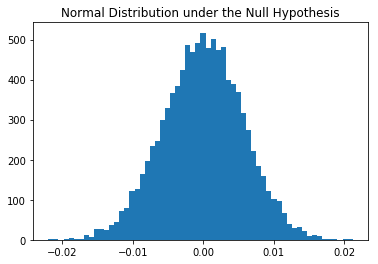

In [121]:
# distribution of our null hypothesis
null_IRRs = np.random.normal(0, np.std(IRRs), 10000)
plt.hist(null_vals, bins=60)
plt.title("Normal Distribution under the Null Hypothesis");

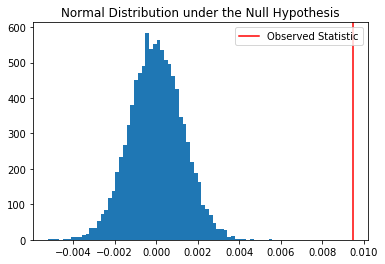

In [122]:
# Reviewing our observed statistic against the bootstrapped sample
plt.axvline(IRR, color='r', label ="Observed Statistic")
null_IRRs = np.random.normal(0, np.std(IRRs), 10000)
plt.hist(null_IRRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis")
plt.legend();

In [124]:
# Calculating the signifigance of this result 
pval_IRR = (IRR>null_IRRs).mean()
pval_IRR

1.0

<a id="Part3Conc"></a>
#### Part III. Conclusion 
Our P value is well above our null distribution and therefore we **reject the null hypothesis**. This implies that there is a statistical increase in IRR between our control and experiemental group. So, we can see that our campaign does have a positive affect on the number of customers who purchased the product with the promotion, as compared to if they didn't receive the promotion. 
<a id="Part4"></a>
### Part IV. Model Creation 
Here we shall a model that can accuractely predict if a customer will be responsive to the campaign. 

In [3]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
train_data.shape

(84534, 10)

In [5]:
# Reviewing the number of individuals who purchased products in both the control and experiment condition 
train_data.groupby('Promotion').purchase.sum()

Promotion
No     319
Yes    721
Name: purchase, dtype: int64

In [6]:
# Copying the dataframe over 
data_exp = train_data.copy()

In [7]:
# only considering the experiment group for our model training 
data_exp = data_exp[data_exp['Promotion']=="Yes"]

In [8]:
# Dropping the irrelavant columns 
data_exp.drop(['ID','Promotion'], axis = 1, inplace=True)

In [9]:
# Checking the shape is correct
data_exp.shape

(42364, 8)

In [10]:
# Viewing our data again 
data_exp.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
4,0,3,28.044332,-0.385883,1,1,2,2
8,0,2,31.930423,0.393317,2,3,1,2
10,0,1,32.770916,-1.511395,2,1,4,1
12,0,1,36.957009,0.133583,2,3,1,1
14,0,3,36.911714,-0.905350,2,2,4,1


In [11]:
# Splitting our data into predictors and target variables
X = data_exp.drop(['purchase'],axis=1)
y = data_exp.purchase

In [12]:
# Scaling our inputs 
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
# Instantiating our model and fitting it
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
# Loading in our test data 
test_data = pd.read_csv('./test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [15]:
# Tailoring the test data to test our model 
data_exp_test = train_data.copy()
data_exp_test = data_exp_test[data_exp_test['Promotion']=="Yes"]
data_exp_test.drop(['ID','Promotion'], axis = 1, inplace=True)
X_test = data_exp_test.drop(['purchase'],axis=1)
y_test = data_exp_test.purchase

In [16]:
# Scaling our test input 
X_test = min_max_scaler.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [17]:
# Predicting our target values
y_pred = clf.predict(X_test)

In [19]:
# Checking our accuracy for the model 
accuracy = (y_pred == y_test).mean()
print("Our accuracy for the random forest model was {0:.5f}%".format(accuracy))

Our accuracy for the random forest model was 0.99991%


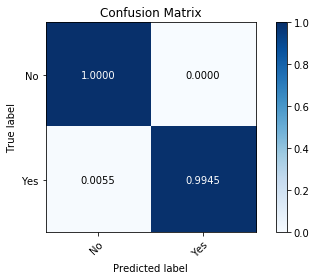

In [20]:
### Creating a confusion matrix visual

confusion_matrix = confusion_matrix(y_test, y_pred)
classes = ['No','Yes']
confusion_matrix  = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
        yticks=np.arange(confusion_matrix.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title="Confusion Matrix",
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

fmt = '.4f'
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], fmt),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")
fig.tight_layout()
ax;

In [21]:
# Converting our numeric outputs to Yes/No's 
promotion_yes_no = []
for value in y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
    

In [22]:
# Converting to a NumPy Array 
np.asarray(promotion_yes_no)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [25]:
# Creating the function to pass to our test_results function
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df = min_max_scaler.fit_transform(df)
    
    y_pred = clf.predict(df)
    
    promotion_yes_no = []
    for value in y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")
            
    promotion = np.asarray(promotion_yes_no)
    
    
    
    
    return promotion

In [27]:
# This will test our results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0476.

Your nir with this strategy is 6.85.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.047619047619047616, 6.85)

<a id="Part4Conc"></a>
### Model Conclusion

Ha! So, we managed to get a better IRR but a signifigantly worse nir than the experts over at Udacity... Regardless, we still managed a signifigantly better approach than what we had observed with the experiment. 

Our confusion matrix indidcated that our accuracy is only hindered by a small number of false negatives. Prehaps if we had a less conservative model we may see a **higher NIR** rate. Allowing for a higher number of false positives may actually improve our NIR metric at the cost of our IRR. 

So to recap, 
- We trained our model on only those individuals in the experiment (i.e. they were offered the promotion)
- Our model would than predict whether or not the individuals would purchase from the promotion offer based on the predicitor variables
- We than tested our models NIR and IRR metrics using a local python script.

